# Store and query OpenAI embeddings in Azure SQL DB (TSQL)

### **Vector Similarity search in SQL DB.**

- Data set used : [Fine Foods Review Dataset](https://github.com/Azure-Samples/azure-sql-db-vector-search/blob/a181e15337402e568f4fc66fe5941e5973171972/VectorSearch_Notebooks/Datasets/Reviews.csv)  <span style="background:white;">is available on Kaggle. This dataset consists of reviews of fine foods from amazon.</span>
- For this tutorial to demonstrate storing and querying vectors in SQL we will be using a smaller sample of  [finefoodembeddings.csv](https:\github.com\Azure-Samples\azure-sql-db-vector-search\blob\a181e15337402e568f4fc66fe5941e5973171972\VectorSearch_Notebooks\Datasets\finefoodembeddings.csv)
    
    ### **Prerequisites:**
    
    - An Azure subscription - [Create one for free](https:\github.com\Azure-Samples\azure-sql-db-vector-search\blob\622f7be47cafa261b267163a9a94af13d4fa9243\AzureSQLVectorSearch\src\https:\azure.microsoft.com\free\cognitive-services?azure-portal=true)
    - Azure SQL Database - [Create one for free](https:\github.com\Azure-Samples\azure-sql-db-vector-search\blob\622f7be47cafa261b267163a9a94af13d4fa9243\AzureSQLVectorSearch\src\https:\learn.microsoft.com\azure\azure-sql\database\free-offer?view=azuresql)
    - [Azure Data Studio](https:\azure.microsoft.com\products\data-studio) to connect to an Azure SQL database & run the notebook. 
    - Make sure you have an [Azure OpenAI](https:\learn.microsoft.com\en-us\azure\ai-services\openai\overview) resource created in your Azure subscription. For this specific sample you have to deploy an Embedding model using the **text-embedding-small** model, the same used for the source we are using in this sample. Once that is done, you need to get the API KEY and the URL of the deployed model  [Embeddings REST API](https:\learn.microsoft.com\azure\cognitive-services\openai\reference#embeddings). And then you can use the    [sp\_invoke\_external\_rest\_endpoint](https:\learn.microsoft.com\sql\relational-databases\system-stored-procedures\sp-invoke-external-rest-endpoint-transact-sql?view=azuresqldb-current) to call the REST API from Azure SQL database.

### **Importing the data into SQLDB**

Import the data from the [finefoodembeddings.csv](https:\github.com\azure-samples\azure-sql-db-vector-search\blob\622f7be47cafa261b267163a9a94af13d4fa9243\azuresqlvectorsearch\src\azuresqlvectorsearch\dataset\finefoodembeddings.csv)  to the finefoodreviews table.

You can use the [SQL Server Import extension](https:\learn.microsoft.com\en-us\azure-data-studio\extensions\sql-server-import-extension) available in the [Azure Data Studio](https:\azure.microsoft.com\products\data-studio) that converts .txt and .csv files into a SQL table . The step by the step instructions to do this can be found  [here](https:\learn.microsoft.com\en-us\azure-data-studio\extensions\sql-server-import-extension)<span style="font-size:12.0pt;font-family:&quot;Segoe UI&quot;,sans-serif;color:#161616;background:white;">.</span>

1\. Connect to your database server and select the database and the table name

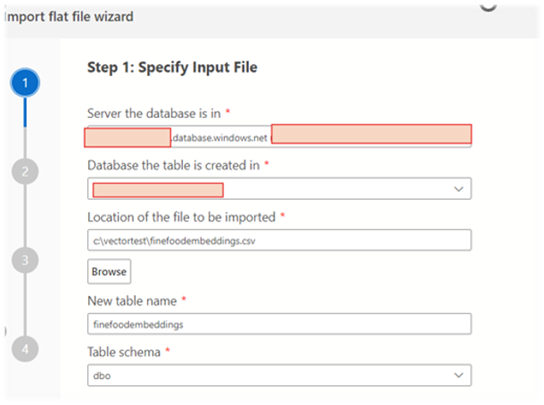

2.Ensure you modify the datatypes to the below before importing the CSV

<span style="font-size:9.0pt;font-family:Consolas;color:#212121;">[Id] [bigint] </span> <span style="font-size:9.0pt;font-family:Consolas;color:blue;">NOT NULL</span><span style="font-size:9.0pt;font-family:Consolas;color:#212121;">,</span>

<span style="font-size:9.0pt;font-family:Consolas;color:#212121;">[ProductId] [nvarchar](</span><span style="font-size:9.0pt;font-family:Consolas;color:#09885A;">500</span><span style="font-size:9.0pt;font-family:Consolas;color:#212121;">) </span> <span style="font-size:9.0pt;font-family:Consolas;color:blue;">NULL</span><span style="font-size:9.0pt;font-family:Consolas;color:#212121;">,</span>

<span style="font-size:9.0pt;font-family:Consolas;color:#212121;">[UserId] [nvarchar](</span><span style="font-size:9.0pt;font-family:Consolas;color:#09885A;">50</span><span style="font-size:9.0pt;font-family:Consolas;color:#212121;">) </span> <span style="font-size:9.0pt;font-family:Consolas;color:blue;">NULL</span><span style="font-size:9.0pt;font-family:Consolas;color:#212121;">,</span>

<span style="font-size:9.0pt;font-family:Consolas;color:#212121;">[Time] <a title="c:\vectortest\azure-sql-db-vector-search\VectorSearch_Notebooks\SQL_Notebook_Example\/50" rel="nofollow">nvarchar</a> NULL</span>

<span style="font-size:9.0pt;font-family:Consolas;color:#212121;">[score] [bigint] </span> <span style="font-size:9.0pt;font-family:Consolas;color:blue;">null</span><span style="font-size:9.0pt;font-family:Consolas;color:#212121;">,</span>

<span style="font-size:9.0pt;font-family:Consolas;color:#212121;">[summary] <a title="c:\vectortest\azure-sql-db-vector-search\VectorSearch_Notebooks\SQL_Notebook_Example\/max" rel="nofollow">nvarchar</a> </span> <span style="font-size:9.0pt;font-family:Consolas;color:blue;">NULL</span><span style="font-size:9.0pt;font-family:Consolas;color:#212121;">,</span>

<span style="font-size:9.0pt;font-family:Consolas;color:#212121;">[text] <a title="c:\vectortest\azure-sql-db-vector-search\VectorSearch_Notebooks\SQL_Notebook_Example\/max" rel="nofollow">nvarchar</a> </span> <span style="font-size:9.0pt;font-family:Consolas;color:blue;">NULL</span><span style="font-size:9.0pt;font-family:Consolas;color:#212121;">,</span>

<span style="font-size:9.0pt;font-family:Consolas;color:#212121;">[combined] <a title="c:\vectortest\azure-sql-db-vector-search\VectorSearch_Notebooks\SQL_Notebook_Example\/max" rel="nofollow">nvarchar</a> </span> <span style="font-size:9.0pt;font-family:Consolas;color:blue;">NULL</span><span style="font-size:9.0pt;font-family:Consolas;color:#212121;">,</span>

<span style="font-size:9.0pt;font-family:Consolas;color:#212121;">[vector] [varchar](</span><span style="font-size:9.0pt;font-family:Consolas;color:#09885A;">max</span><span style="font-size:9.0pt;font-family:Consolas;color:#212121;">) </span> <span style="font-size:9.0pt;font-family:Consolas;color:blue;">NULL</span>

<span style="font-size:9.0pt;font-family:Consolas;color:blue;"><br></span>

 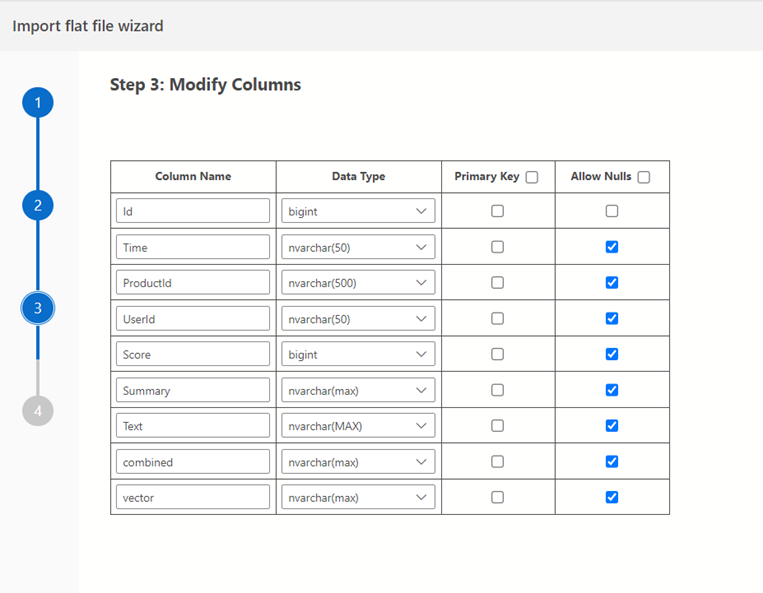

4\. Once you have successfully inserted the data, we can now try our new vector functions.

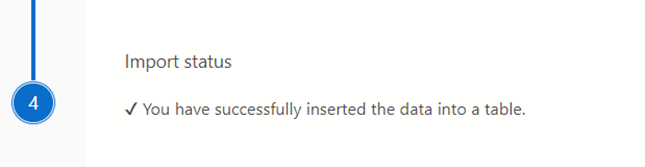

### **Using your Azure Open AI Resource & setting up an Embedding Model:**

Make sure you can access OpenAI service by following the documentation here: [How do I get access to Azure OpenAI?](https://learn.microsoft.com/azure/ai-services/openai/overview#how-do-i-get-access-to-azure-openai).

Then retrieve the **Azure OpenAI _endpoint_ and _key_**:

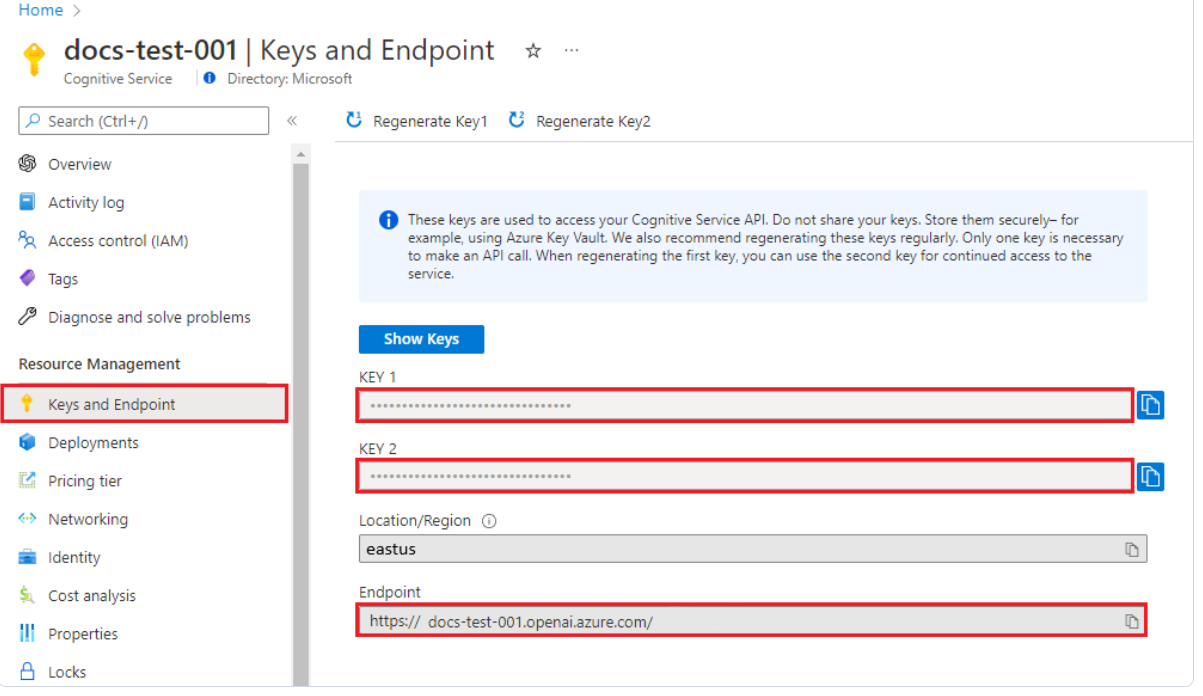

Deploy an embedding model - for example the `text-embedding-small` - following the [Create and deploy an Azure OpenAI Service resource](https://learn.microsoft.com/azure/ai-services/openai/how-to/create-resource)  
**Note down the Model Deployment name** as you will need to add it to the Stored procedure later.

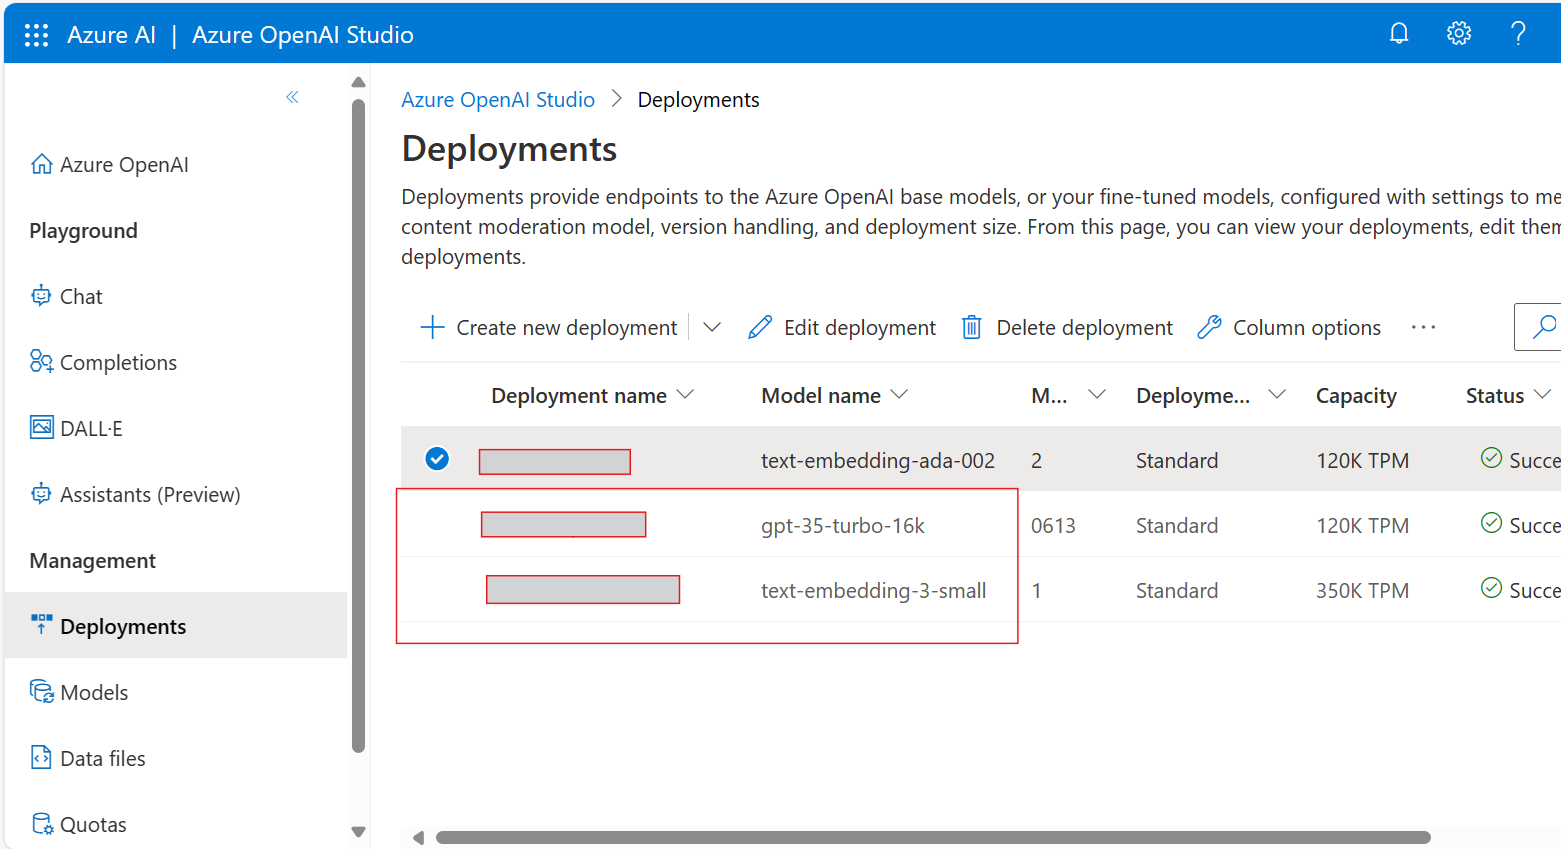

Lets now begin with the notebook.  
You can run the following notebook using the [SQL Kernel for Notebooks in Azure Data Studio](https:\learn.microsoft.com\en-us\azure-data-studio\notebooks\notebooks-guidance#connect-to-a-kernel) . See here for more [info](https:\learn.microsoft.com\en-us\azure-data-studio\notebooks\notebooks-sql-kernel)

In [1]:
/*Lets take a look at the data in the table. The dataset has been created using the customer reviews from FineFoods Amazon and enriching it with embeddings generated via the text-embedding-small OpenAI model.
The embeddings have been generated using the concatenation of Summary + Text
*/

select top(5) * from dbo.finefoodreviews 
order by ID

(5 rows affected)

Total execution time: 00:00:00.622

Id Time ProductId UserId Score Summary Text combined vectorbinary vectorbinary1 1 1303862400 B001E4KFG0 A3SGXH7AUHU8GW 5 Good Quality Dog Food I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most. Title: Good Quality Dog Food; Content: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most. 0xA901000600000000BE15AB3CBF8A6BB9C74BFBBA63F08EBC8BC3743CFEBAB3BCF2CA56BC6A54583DDDC40B3DF8BD93BC38639C3D27FD2ABD419DA0BC628531BB955A3FBC0FA8303D33E9D3BC2DE87F3CDCE039BDDD394C3B48F3523DE7DEADBBD1E245BD14B71B3DD8B520BCA5EEA9BBF852B6BC101DF13CBAF8283D4A4202BDDC55FABC5BB68ABC65CC78BABF11F7BB193BC7BC8C3C693B55C3CD3CEBFB2FBD486C473D23D211BD48F706BD2868083DFD530A3D4E5F843CF2D86D3D80D74B3B38DC103D4BA92B3B294472BC1C7477B980C9343CB2BA703CC0F5C83CAA76093D8731323DBF8AEBBCA7C0B03CB4FB08BB6EEE82BC72199C3C76B9F5BB0C006FBC0014463D11F3AB3C159739BC1C7477BD528A9DBDA8A482BDFFA8E83CCD3021BB8302653C1E4A323C3274133C69DF973C67949CBC6874BA3B8F6BB6BCD0F05CBB7BC8603D54C7813CFFA868BDA9806C3D73722EBD007F23BCC320E2BCD7D502BD896E963CB06512BCC8A8C13C2D65283CAB643E3D5D845DBB45BA22BD76B975BCB409203DB6CD0F3CADAF39BA076E2C3D43F27EBCC4124B3AD2B880BB2267B43C6E7FF139B317373DFB080F3DE925F5BC6966233D502DD7BB4D7BB23CF66EE4BC6962EFBBCCD78E3BB6541BBD6EEACEBB8AD53FBDF66E64BD9DA25ABC184D12BD76326ABDC57D28BC469AC0BCE1DD593DF0FC83BC5E7646BD87A672BC745680BC2FB0233DBE15AB3C9BD4873BB65067BD0940B33B6457B8BCDD39CC3C7FE5E2BC21008BBDFF9AD1BBD5F130BDF8CB2A3BFE41BFBC70C0893D4C89C93CF66E64BDBF7C543C7BC8603CB2B00D3D881150BDDC4B17BDFA99FDBC50318B3C47016A3D729CF3BC2AAF4F3DD8B5A0BD5967DB3CA6CE473D9985D83C13C5B23CBF8008BC7F6CEEBCADA1223D7F6CEEBCEB82BBBB611E88BBDD39CC38F2D8EDBC5959C43BC320E2BB6ACD4CBC4701EABCB8ADADBC74DD0B3D7881193CE1DD593B5FD30CBD0C79E3BBDD4763BD418F893A6EEACEBC4BA5F73C6ADB63BC4AC98DBC2E61F43C87AA263D38DC10BC5A4B2DBDA739A53CF171C4BCA1C3103D554A593BB229023DEEB108BD4D6D9BBD2AB3033C998558BC562EAB3CA054FFBCD5F130BBE0FD3B3CC320E23CA6CE473CB73439BB6E715ABB688685BB7FE562BCD7C3B7BBB742503BDC592EBD0B123A3D97B785BCB23365BDADA1223C8FF2413B40242CBD54C7013DD1E2C53CFBF6C33A99FECCBB7C25273D3BAAE33C4C10D53C09B9273DE673D0BB94EF613DD5F130BC9059EBBC3871333BA992B73BBCBC98BD94EFE13B63771ABD4C89C9BB47051EBCC499D6BC5DFDD13A5FD38CBCD586D33CD74A433DAE084C3DEA175E3D04B8533C2692CDBC0FA8B03C1CF19FBC1101433DCA05083DAD282E3B5DFDD1BCB89F96BD74DD8BBC4C10D53BD06D053C76B9F53C9AF0353D261959BD076A783DD0F0DC3A73F939BD0C6F00BC562E2BBCE1E18DBA30A20CBD0B12BA3CDE2B353DFA997D3C61A15FBDADAF393DC74FAF3C50B8163D9AE29EBC15A5D03CB650E7BB879C8FBC3F4E71BCF1632D3BF0838F3C43E467BCD5F130BCB7C9DB3C142CDC3CFB045B3D6F63C3BD184D123C929A03BD55B5B6BD3270DF3CFB045BBCD586533BAE08CCBC2C850A3DE7490BBCEA175E3C427DBE3C8389703C0B7D17BDC2322D3DDEB2C03C3BA0803C9A69AA3CB39E423DF7604DBD24393B3D1096E53C55B536BB32F7EA3C54C701BD6EF8653C90596B3DB65067BCF7E7D8BCF7D9413D1F3C1B3DD06D053D91C4C83CECDF01BD378DE13C9897A3BCB65E7EBC6C2A93BC53E32FBC3A316FBC21FCD63CECDF81BBD15BBA3CBE9CB63B881504BCA72B0EBDE83740BC1D5849BCCC4C4FBBDDC40BBC9893EFBC43E81B3D9DB0F1BCABDDB23C990C64BDA2B145BB730751BB3FB94EBCE248B73B7C33BE3B90D693BC151E45BD3E5225BD058E0E3D436FA7BC5D84DD3CDB79103D8B409D3CFF215DBC97A5BA3C27761F3CB233E53CF8441FBA486CC7BC9985D8BB23591DBCE66539BD59EE66BBC499D6BC01718C3B9C37FDBBA1C3903C419D203C0014463D4361903B947A21BB98890CBA729C73BDBAF8283B1F2E843C6E750E3D3C801E3D6A5458BCE248B73CF1EA38BD1DDF543DEA9E693C81BB1D3D18E234BD210EA23CA0547F3D4116153D185775BA34BF8EBCE164E53CF3434B3C219179BD4AB7423D436BF3BC4D6D9BBCFC61213B327493BDA647BCBC53E3AFBBEA09C7BC8898DB39D4946ABD4A42023C2B1A2DBDCA05083C1D58493DF6EB8C3C8CB911BD02D8B53C8551943C97B7853BCEA995BA4788F53C1AA6A4BBBD

In [45]:
--To have the broadest compatibility with any language and platform in the first wave vectors will take advantage of existing VARBINARY data type to store vector binary format
--Add the New Column: vector with the type varbinary(8000)
ALTER TABLE [dbo].[finefoodreviews]
ADD [vectorbinary] varbinary(8000);

Commands completed successfully.

Total execution time: 00:00:00.178

In [30]:
--Then, update the new column with the transformed data from the embedding column.
--We will pass the embeddings to the new built in function JSON_ARRAY_TO_VECTOR that will converts a JSON array to a compact binary representation of a vector
UPDATE [dbo].[finefoodreviews]
SET [vectorbinary] = JSON_ARRAY_TO_VECTOR([vector]);

GO
-- We can drop the previous vector column now as we will be using compact binary representation of a vector in the column vectorbinary created before this.
ALTER TABLE dbo.finefoodreviews
DROP COLUMN vector;

(10000 rows affected)

Commands completed successfully.

Total execution time: 00:00:12.823

In [31]:
-- Vectors are stored in an efficient binary format that also enables usage of dedicated CPU vector processing extensions like SIMD and AVX.      
select top(5)  ID, ProductId text, summary , vectorbinary  from [dbo].[finefoodreviews]




(5 rows affected)

Total execution time: 00:00:00.210

ID text summary vectorbinary 1 B001E4KFG0 Good Quality Dog Food 0xA901000600000000BE15AB3CBF8A6BB9C74BFBBA63F08EBC8BC3743CFEBAB3BCF2CA56BC6A54583DDDC40B3DF8BD93BC38639C3D27FD2ABD419DA0BC628531BB955A3FBC0FA8303D33E9D3BC2DE87F3CDCE039BDDD394C3B48F3523DE7DEADBBD1E245BD14B71B3DD8B520BCA5EEA9BBF852B6BC101DF13CBAF8283D4A4202BDDC55FABC5BB68ABC65CC78BABF11F7BB193BC7BC8C3C693B55C3CD3CEBFB2FBD486C473D23D211BD48F706BD2868083DFD530A3D4E5F843CF2D86D3D80D74B3B38DC103D4BA92B3B294472BC1C7477B980C9343CB2BA703CC0F5C83CAA76093D8731323DBF8AEBBCA7C0B03CB4FB08BB6EEE82BC72199C3C76B9F5BB0C006FBC0014463D11F3AB3C159739BC1C7477BD528A9DBDA8A482BDFFA8E83CCD3021BB8302653C1E4A323C3274133C69DF973C67949CBC6874BA3B8F6BB6BCD0F05CBB7BC8603D54C7813CFFA868BDA9806C3D73722EBD007F23BCC320E2BCD7D502BD896E963CB06512BCC8A8C13C2D65283CAB643E3D5D845DBB45BA22BD76B975BCB409203DB6CD0F3CADAF39BA076E2C3D43F27EBCC4124B3AD2B880BB2267B43C6E7FF139B317373DFB080F3DE925F5BC6966233D502DD7BB4D7BB23CF66EE4BC6962EFBBCCD78E3BB6541BBD6EEACEBB8AD53FBDF66E64BD9DA25ABC184D12BD76326ABDC57D28BC469AC0BCE1DD593DF0FC83BC5E7646BD87A672BC745680BC2FB0233DBE15AB3C9BD4873BB65067BD0940B33B6457B8BCDD39CC3C7FE5E2BC21008BBDFF9AD1BBD5F130BDF8CB2A3BFE41BFBC70C0893D4C89C93CF66E64BDBF7C543C7BC8603CB2B00D3D881150BDDC4B17BDFA99FDBC50318B3C47016A3D729CF3BC2AAF4F3DD8B5A0BD5967DB3CA6CE473D9985D83C13C5B23CBF8008BC7F6CEEBCADA1223D7F6CEEBCEB82BBBB611E88BBDD39CC38F2D8EDBC5959C43BC320E2BB6ACD4CBC4701EABCB8ADADBC74DD0B3D7881193CE1DD593B5FD30CBD0C79E3BBDD4763BD418F893A6EEACEBC4BA5F73C6ADB63BC4AC98DBC2E61F43C87AA263D38DC10BC5A4B2DBDA739A53CF171C4BCA1C3103D554A593BB229023DEEB108BD4D6D9BBD2AB3033C998558BC562EAB3CA054FFBCD5F130BBE0FD3B3CC320E23CA6CE473CB73439BB6E715ABB688685BB7FE562BCD7C3B7BBB742503BDC592EBD0B123A3D97B785BCB23365BDADA1223C8FF2413B40242CBD54C7013DD1E2C53CFBF6C33A99FECCBB7C25273D3BAAE33C4C10D53C09B9273DE673D0BB94EF613DD5F130BC9059EBBC3871333BA992B73BBCBC98BD94EFE13B63771ABD4C89C9BB47051EBCC499D6BC5DFDD13A5FD38CBCD586D33CD74A433DAE084C3DEA175E3D04B8533C2692CDBC0FA8B03C1CF19FBC1101433DCA05083DAD282E3B5DFDD1BCB89F96BD74DD8BBC4C10D53BD06D053C76B9F53C9AF0353D261959BD076A783DD0F0DC3A73F939BD0C6F00BC562E2BBCE1E18DBA30A20CBD0B12BA3CDE2B353DFA997D3C61A15FBDADAF393DC74FAF3C50B8163D9AE29EBC15A5D03CB650E7BB879C8FBC3F4E71BCF1632D3BF0838F3C43E467BCD5F130BCB7C9DB3C142CDC3CFB045B3D6F63C3BD184D123C929A03BD55B5B6BD3270DF3CFB045BBCD586533BAE08CCBC2C850A3DE7490BBCEA175E3C427DBE3C8389703C0B7D17BDC2322D3DDEB2C03C3BA0803C9A69AA3CB39E423DF7604DBD24393B3D1096E53C55B536BB32F7EA3C54C701BD6EF8653C90596B3DB65067BCF7E7D8BCF7D9413D1F3C1B3DD06D053D91C4C83CECDF01BD378DE13C9897A3BCB65E7EBC6C2A93BC53E32FBC3A316FBC21FCD63CECDF81BBD15BBA3CBE9CB63B881504BCA72B0EBDE83740BC1D5849BCCC4C4FBBDDC40BBC9893EFBC43E81B3D9DB0F1BCABDDB23C990C64BDA2B145BB730751BB3FB94EBCE248B73B7C33BE3B90D693BC151E45BD3E5225BD058E0E3D436FA7BC5D84DD3CDB79103D8B409D3CFF215DBC97A5BA3C27761F3CB233E53CF8441FBA486CC7BC9985D8BB23591DBCE66539BD59EE66BBC499D6BC01718C3B9C37FDBBA1C3903C419D203C0014463D4361903B947A21BB98890CBA729C73BDBAF8283B1F2E843C6E750E3D3C801E3D6A5458BCE248B73CF1EA38BD1DDF543DEA9E693C81BB1D3D18E234BD210EA23CA0547F3D4116153D185775BA34BF8EBCE164E53CF3434B3C219179BD4AB7423D436BF3BC4D6D9BBCFC61213B327493BDA647BCBC53E3AFBBEA09C7BC8898DB39D4946ABD4A42023C2B1A2DBDCA05083C1D58493DF6EB8C3C8CB911BD02D8B53C8551943C97B7853BCEA995BA4788F53C1AA6A4BBBD358DBC8E040D3D59E04F3C6293C83B6CA387BB369F2CBC5198343CEE34603CDBF2843DC74B7BBC7BBA493CA5EE29BD18D0E9BC0B8BAEBBC5F61C3D9CB4A5BBBE23C2BC5A4B2D3D65C215BD094033BD14B71BBDF67298BDFA9D313C167B0B3D595944BC59E403BD671BA8BD2F4546BDCC4CCFBC034DF6BCAAEBC9BC0A2405BDDE1D9EBCED462B3CFFA868BD5EEF3ABDEA175E3C896E163DE9A29DBAD07B1C3B6BBF35BDCBE1713CB2B08D3B444FC53A5BB68ABC728E5CBB6A54583D8302E53B14A904BDEA9E693C5C92F4BCD077E83CFB8B663C486CC73C7C33BEBBD2C6973CC32062BB19C2523CC833813C167B0B3DD07B1CBDD411133D5875F2BCC82FCDBC6DFC99BC033F5F3CBC51BBBC5FD38C3C076EAC3CF25FF93C2948A63C3FCB193C2ABD663CBAF828BD50B8163D8903B9BCA655D33C0C79633CC1CB03BDA39517BDF25FF9

In [32]:
/*
On that table we can create a column store index to efficiently store and search for vectors. Then it is just a matter of calculating the distance between vectors to find the closest. 
Thanks to the internal optimization of the columnstore (that uses SIMD AVX-512 instructions to speed up vector operations) the distance calculation to find the exact nearest neighbour search is extremely fast
*/
create clustered columnstore index Csindex on [dbo].[finefoodreviews]
order (ID, vectorbinary)
go

Commands completed successfully.

Total execution time: 00:00:04.944

In [33]:
/*
Specialized functions will allow developers to transform stored vector data back into JSON arrays and to check and mandate vector dimensionality. 
Lets take a look at how the vector is stored in the SQL DB table & also make use of the newly introduced helper functions
ISVECTOR Checks if the provided object is a valid vector: Returns 1 if valid, otherwise returns 0. Returns NULL if the expression is NULL
VECTOR_DIMENSIONS Takes a vector as an input and returns the number of dimensions as an output. In this case we see the number of dimensions of the vector are 1536 (as we are using Azure OpenAI text embeddings)
VECTOR_TO_JSON_ARRAY Converts a vector in a compact binary format to a human-readable string format. The string format is the same as the one used by JSON to represent arrays
*/

SELECT TOP(5) ISVECTOR(vectorbinary) as isvector, VECTOR_DIMENSIONS(vectorbinary) as dimensions , summary , vectorbinary , VECTOR_TO_JSON_ARRAY(vectorbinary) as jsonvector,  ProductId FROM [dbo].[finefoodreviews]


(5 rows affected)

Total execution time: 00:00:00.287

isvector dimensions summary vectorbinary jsonvector ProductId 1 1536 Absolutely delicious coffee! 0xA90100060000000056035CBD6A6A0CBD2700DFBC57C6E1BCA76B9CBBAC1487BD5EE23EBC93B4583DA8DE8E3C51F744BCE58F0B3D376E91BB8DF854BCFECBFEBB729902BC5CBC8C3DF00713BD8B7249BCAE9A123C95D7B73C3CDDD4BADD63E83B486875BD8AFC033D231AFABA0029853CD06282BD9F3C26BC28C364BCA3E863BD109A0ABD0375693B1173FCBC1FBECFBBF007933CA71B09BDD3E88D3B741F0E3D32B28D3B7FE7A83C485289BCF7869C3C19EF323DA3D54ABC729902BD122016BC816DB43CD8A491BCF676D6BBE93B49BC623EE9BCAAB42D3D816D343DE99E75BB521D773C27B0CBBC36AB8BBB30EF873C0538EF3C7C4E043DE6F2B73C8EBBDABC4FD1123A18DC993C070B3BBBA77E35BD53E0FCBC598614BDCE05FC3C54CA103D969ABDBCB1D00A3CB962ADBBDBDD5CBD6068CABC844000BD1D981DBCD288B4BBCBBC6ABC39A7DCBC32153ABD725FDB3CEE8187BBF38D1E3C56509CBC75E213BD50E4ABBCC38DF4BC4D5EA0BCACDADFBCC1A43CBB49B5B5BC56B3483D9F290D3CAB175A3C5DCF253D3944303D13965B3DB8FF003C6DB6703C776BF23CD1285B3C96EAD0BCADD70C3C5047583D6734943BE5DF1E3D3C678F3CC15429BD7DD762BC27005FBD315234BBC87006BDA435243C1B1212BD196578BDDBDDDC3B247A53BC56A0AFBCB68FE1BCC044E3BCBE1E313C3EB3F3BA2E1CBC3C2DCFFBBB969ABDBCBEBB843CE1F9393CA1AF18BCB68F61BCAA51813CB702D4BC5D7F12BD6FC6B6BCE309003BE26FFF3C969ABDBB188FD9BCCE057CB9A448BD3CB702543C8B22B6BDBF7E8A3B5713A23B4BD814BDDD9D8FBD3B6A62BD8B22B6BC732261BDFFB5123D7C619DBD05852FBCADD70CBD8889113DF43D8BBC15568E3CE1E6203DAD3A393D6DA084BCF739DCBBA3D5CA3C741F0EBBFB32DABCEC5E283C4C4E5ABD4D11603C21946E38553D03BC2F8FAEBC013C1EBB72FC2EBB03AF103C725F5BBA68E480BC730FC83C8490933BCEA24FBD907EE03C4852093D8EA8C1BCDB2A1D3D26ED453D8666323D8AFC03BDD8F4A43C7E9AE83C32C5263CBC4892BCC20496BBFC2F873B34EB583CDBDDDCBB252A40BD018CB1BB61C8A33BEB4B8F3C9E3FF93C7692803D52070BBDA8914E3C0CB425BC3EB3733C617B63BCC6B0D3BAE1F939BCF2CA983BF16A3F3C878CE43C5D95FEBCE6F2B7BCA4E5103D201EA93C7FE7283C20D1683D9427CBBC075B4EBB0538EFBBCD42F6BAB57CC8382C461D3DA5F829BCC4DAB43CEC5E283DA0EC12BCC9F9643DE65564BCCB09AB3C50E42BBD05351CBCD1C5AE3B60059E3CD3AEE63CCC7FF0BB849013BD407679BCBEBB84BB69A7063D3994433DDF73AE3CE1E6A0BCAC7733BD4C8881BBFDA5CC3895748B3C0425D6BB28FD0BBDF77383BC6CF36ABD247A53BD05852FBD2F2C023D7D118A3CE5DF1EBCA435A43C1446483CBE1EB13A974A2A3DD61E06BDD1285B3DC550FABC633B96BCB9D8F23C30F25ABBE20CD3BC2DCF7BBDF00A663DB7EFBABC65C474BD776BF23A9D66873CC2CAEEBC394430BD435CDE3C29233E3DB68FE1BBD34BBA3C22F447BCC38D74BDAC27A03C5B0FF3BC7B9E17BD884FEABC68E4803C36C177BD8F6BC73C2F2C82BCEE81073C8B22B6BC537DD0BC0A2E9ABC884FEA3BA2255EBD6D53443C3A07B6BBC9330CBB451C913CF613AABCF7D62F3C03AF90BC9587A43B4B8B543DF43D0B3DB8B2C03CB5191C3D28FD8B3BD238A13CEBAE3B3D16B9BA3B1F0B10BD48A21CBB9F3CA6BC17DFECBB02EC8A3DD91AD7BCFB826DBCF45024BD3F9D873C776BF2BC333BECBCC1A4BCBC8C820F3CCD7C9DBB8C98FB3B8B72C9BC60051EBD1B753EBD7C611D3D3A57C93B617BE33BE6A2A4BDB84F14BB08BB273C5D95FEBC09CE40BC8FB887BDBE815DBDBB9B78BCEC5E28BD0079983C52070BBB884FEABCD7E18BBB4A28A8BC00DCC4BCE1ACF93CC8D3323D263D593D834353BCADEA253B5EF5573D4A158FBCCCB9973C805D6EBC51F7C43CBB858C3DF739DCBCD55B00BC8440003D0EEDF0BC542D3D3C372151BC0D2A6B3C53E0FCBB9933E23C98AA83B8678427BDE81517BCC6FD13BD0E2718BDB2A9FC3CE47F453C86C95E3D7708C6B910B0F63B92A1BFBD53E0FC3CD06282BC36C177B8A498D03CA82E223DA448BD3D440C4BBB05359C3B2D0923BD81BD473DE58F8BBC1E480ABDEBAE3BBD3A07363DB75267BC4D4B07BCF67656BC1D4BDDBC06FB743C821DA1BCBB384C3DA04FBF3A8C354F3DD2EBE0BB2910A5BC18DC19BBF27A05BDCFEF0FBD3EB373BC68AA593B504758BCD3AE66BCFC45F33CEBFECEBC923E13BC1965F83CB6DC21BD0079183D7645C03C8D4515BD8553193D9F8C393C47A5EF3BC1B7D5BB0E77AB3CEFA739BD821DA13BB2E3A3BC199F1F3DB2A97C3C8406D93CCD7C1D3DC54D27BD798E51BD66877ABC9364C5BCE0E9F33CE605513D3AF49C3C6ABA9FBC5A99ADBC2BE6C3BDF949A23B8EA8C1BCDBDDDC3C1F0B10BD4B3B413C0E2798BCC9E6CBBB5F55B1BD16B9BA3CC54DA73C719C55BB6A6A8C3C6B7DA5BCAB641A3BDB2A9DB81D4BDD3A32C526BD798ED1BC5C0C203DF00713BBF899B5BBA6BB2F3D0FEA1DBD1E480A3C1D981DBDDBDD5CBD17DF6CBD9CB9EDBCEC71C1B8C0F44FBCB3A6293DEAEBB5BCABC7C6BC97ADD63CC9F964BB02FF23BD0ADE863C11ADA3BCC99638BD90CBA03C59D6273D9920493CBBE8383D0ADE06BCA1AF183D9BF6E7BC974A2A3D5889E7BCFCE2

<span style="font-size:11.0pt;mso-bidi-font-size:12.0pt;
line-height:109%;font-family:&quot;Calibri&quot;,sans-serif;mso-fareast-font-family:Calibri;
color:black;mso-ansi-language:EN-IN;mso-fareast-language:EN-IN;mso-bidi-language:
AR-SA">Make sure you have an&nbsp;<a href="https://learn.microsoft.com/en-us/azure/ai-services/openai/overview">Azure OpenAI</a>&nbsp;resource created in your Azure subscription. For this specific sample you have to deploy an Embedding model using the&nbsp;&nbsp;text-embedding-small&nbsp;model, the same used for the&nbsp; source we are using in this sample. Once that is done, you need to get the API KEY and the URL of the deployed model (read the&nbsp;&nbsp;&nbsp;<a href="https://learn.microsoft.com/azure/cognitive-services/openai/reference#embeddings" title="https://learn.microsoft.com/azure/cognitive-services/openai/reference#embeddings">Embeddings REST API</a>&nbsp;&nbsp;&nbsp;documentation) and then you can use&nbsp;&nbsp;&nbsp;<a href="https://learn.microsoft.com/sql/relational-databases/system-stored-procedures/sp-invoke-external-rest-endpoint-transact-sql?view=azuresqldb-current" title="https://learn.microsoft.com/sql/relational-databases/system-stored-procedures/sp-invoke-external-rest-endpoint-transact-sql?view=azuresqldb-current">sp_invoke_external_rest_endpoint</a>&nbsp;&nbsp;&nbsp;to call the REST API from Azure SQL database</span>

<span style="font-size:11.0pt;mso-bidi-font-size:12.0pt;
line-height:109%;font-family:&quot;Calibri&quot;,sans-serif;mso-fareast-font-family:Calibri;
color:black;mso-ansi-language:EN-IN;mso-fareast-language:EN-IN;mso-bidi-language:
AR-SA">Ensure you replace it with your API KEY and URL&nbsp;</span>

In [35]:
/* OpenAI models are available as REST endpoints and thus can be easily consumed from Azure SQL Database using the sp_invoke_external_rest_endpoint system stored procedure:
Using a call to a REST service to get embeddings is just one of the integration options you have when working with SQL Database and OpenAI. 
You can let any of the available models access data stored in Azure SQL Database to create solutions where your users can interact with the data as shown here 
*/

create procedure [dbo].[get_embeddings]
(
    @model varchar(max),
    @text nvarchar(max),
    @embedding varbinary(8000) output
)
as
begin
    declare @retval int, @response nvarchar(max);
    declare @url varchar(max);
    declare @payload nvarchar(max) = json_object('input': @text);

    -- Set the @url variable with proper concatenation before the exec statement
    set @url = 'https://<deploymentname>.openai.azure.com/openai/deployments/' + @model + '/embeddings?api-version=2023-03-15-preview';

    exec dbo.sp_invoke_external_rest_endpoint 
        @url = @url,
        @method = 'POST',   
        @payload = @payload,   
        @headers = '{"Content-Type":"application/json", "api-key":"<openaikey>"}', 
        @response = @response output;

    declare @jsonArray nvarchar(max) = '';
    declare @first bit = 1;

    -- Use a cursor to iterate through the JSON elements and build the array
    declare @value nvarchar(max);
    declare json_cursor cursor for
    select [value]
    from openjson(@response, '$.result.data[0].embedding');

    open json_cursor;
    fetch next from json_cursor into @value;

    while @@FETCH_STATUS = 0
    begin
        if @first = 1
            set @first = 0;
        else
            set @jsonArray = @jsonArray + ',';

        set @jsonArray = @jsonArray + cast(@value as nvarchar(max));
        fetch next from json_cursor into @value;
    end;

    close json_cursor;
    deallocate json_cursor;

    -- Enclose the values in brackets to form a valid JSON array
    set @jsonArray = '[' + @jsonArray + ']';

    -- Convert the JSON array to a vector
    set @embedding = json_array_to_vector(@jsonArray);
end
GO

Commands completed successfully.

Total execution time: 00:00:00.191

### Required Permissions

To execute the stored procedure, the executing principal must have the “execute external endpoint” permissions:

<span style="font-size:9.0pt;font-family:Consolas;
mso-fareast-font-family:Consolas;mso-bidi-font-family:Consolas;color:blue">grant</span> <span style="font-size:
9.0pt;font-family:Consolas;mso-fareast-font-family:Consolas;mso-bidi-font-family:
Consolas;color:blue">execute</span> <span style="font-size:9.0pt;font-family:
Consolas;mso-fareast-font-family:Consolas;mso-bidi-font-family:Consolas;
color:#212121">any </span> <span style="font-size:9.0pt;font-family:Consolas;
mso-fareast-font-family:Consolas;mso-bidi-font-family:Consolas;color:blue">external</span> <span style="font-size:
9.0pt;font-family:Consolas;mso-fareast-font-family:Consolas;mso-bidi-font-family:
Consolas;color:blue">endpoint</span> <span style="font-size:9.0pt;font-family:Consolas;
mso-fareast-font-family:Consolas;mso-bidi-font-family:Consolas;color:blue">to</span> <span style="font-size:9.0pt;font-family:Consolas;mso-fareast-font-family:Consolas;
mso-bidi-font-family:Consolas;color:#212121">[principal]</span>

<span style="font-size:11.0pt;mso-bidi-font-size:12.0pt;line-height:109%;
font-family:&quot;Calibri&quot;,sans-serif;mso-fareast-font-family:Calibri;color:black;
mso-ansi-language:EN-IN;mso-fareast-language:EN-IN;mso-bidi-language:AR-SA">This permission is covered by the </span> <span style="font-size:11.0pt;mso-bidi-font-size:
12.0pt;line-height:109%;font-family:&quot;Courier New&quot;;mso-fareast-font-family:&quot;Courier New&quot;;
color:black;mso-ansi-language:EN-IN;mso-fareast-language:EN-IN;mso-bidi-language:
AR-SA">CONTROL</span> <span style="font-size:11.0pt;mso-bidi-font-size:12.0pt;
line-height:109%;font-family:&quot;Calibri&quot;,sans-serif;mso-fareast-font-family:Calibri;
color:black;mso-ansi-language:EN-IN;mso-fareast-language:EN-IN;mso-bidi-language:
AR-SA">permission, so anyone having </span> <span style="font-size:11.0pt;
mso-bidi-font-size:12.0pt;line-height:109%;font-family:&quot;Courier New&quot;;
mso-fareast-font-family:&quot;Courier New&quot;;color:black;mso-ansi-language:EN-IN;
mso-fareast-language:EN-IN;mso-bidi-language:AR-SA">CONTROL</span> <span style="font-size:11.0pt;mso-bidi-font-size:12.0pt;line-height:109%;font-family:
&quot;Calibri&quot;,sans-serif;mso-fareast-font-family:Calibri;color:black;mso-ansi-language:
EN-IN;mso-fareast-language:EN-IN;mso-bidi-language:AR-SA">permission on server or database will be able to also execute the stored procedure.<br>More info&nbsp;</span>  [here](https:\learn.microsoft.com\en-us\sql\relational-databases\system-stored-procedures\sp-invoke-external-rest-endpoint-transact-sql?view=azuresqldb-current&tabs=request-headers)

In [37]:
/* Performing a similarity search
Lets now query our embedding table to get the top similar reviews given the User search query.

What we are doing: Given any user search query, we can get the vector representation of that text. Then we can use that vector to calculate the cosine distance against all the customer review comments stored in the database and take only the closest ones which will return the product most likely connect to the product we are interested in. The reviews with the highest similarity are considered the most relevant to the query, helping users discover products or experiences related to their search.
The most common distance is the cosine similarity, which can be calculated quite easily in SQL with the help of the new distance functions

This approach showcases the power of semantic search by finding reviews that are contextually related to the search query, even if they don’t contain exact match keywords  */

declare @e varbinary(8000) 
exec dbo.get_embeddings @model = '<yourmodeldeploymentname>', @text = 'help me find healthy cat food', @embedding = @e output;

SELECT TOP(10) ProductId, Summary, text,
           1 -vector_distance('cosine', @e, vectorbinary) AS similarity_score
    FROM dbo.finefoodreviews
    ORDER BY similarity_score desc

(10 rows affected)

Total execution time: 00:00:01.145

ProductId,Summary,text,similarity_score
B003SE19UK,Palatable and healthy,"Before I was educated about feline nutrition, I allowed my cats to become addicted to dry cat food. I always offered both canned and dry, but wish I would have fed them premium quality canned food and limited dry food. I have two 15 year old cats and two 5 year old cats. The only good quality dry foods they will eat are Wellness and Innova. Innova's manufacturer was recently purchased by Procter&Gamble. I began looking for a replacement. After once again offering several samples (from my local holistic pet store) Holistic Select was the only one (other than the usual Wellness and Innova) they would eat. For finicky cats, I recommend trying Holistic Select. It is a good quality food that is very palatable for finicky eaters.",0.6271999928953957
B000VK6NDC,"Highest quality, delicious food for your cats!","My cats both LOVE this food. I've had varying success with about 7 different kinds of canned food. This one is a hit with both. It's natural, mostly organic, doesn't have any junk or fillers, and I have peace of mind knowing that we're giving them high quality food from an ethical company. Since they've been on this diet they are more active, alert and happy. Their coats are so soft and shiny and they seem to be shedding less. Cannot say how relieved I am to have finally found a food they like that is so good for them as well. It is pricey but if you want to save on costly vet bills down the road due to illness caused by poor nutrition, this is the way to go.",0.5938018327837162
B001EX9LGQ,Catfood,Very Healthy ingredients..compared to store brands..My<br />cats love this..they are Fussy Eaters..so I think many<br />cats would love this food..Will Buy it again.,0.5685298553173851
B003R0LKSG,Excellent Grain-Free Option,"We recently adopted a new kitten. We rotate Felidae grain-free canned formula with Wellness Turkey canned food. He loves both and eats well, he's never left a single whole pea behind. This is a very high-quality cat food, using excellent all-meat proteins. He is healthy, active,affectionate, and has a smooth glossy coat. Definitely worth the cost in the long run.<br /><br />I believe it is worthwhile to rotate different (high-quality) canned foods for variety and to not create a cat who will ONLY eat one brand. I think this is useful also in the event of a recall. I'm looking for a 3rd high-quality brand to add to the rotation.",0.567794291363927
B003SE19UK,Healthy & They LOVE It!,"My holistic vet recommended this, along with a few other brands. We tried them all, but my cats prefer this (especially the sardine version). The best part is their coats are so soft and clean and their eyes are so clear. AND (and I don't want to be rude, so I'll say this as delicately as I can) their waste is far less odorous than cats who eat the McDonalds junk found in most stores, which is a definite plus for me! The health benefits are so obvious - I highly recommend Holistic Select!",0.5660357548382248
B000VK6NDC,16 cats love it...,"I have 16 cats ranging from 1 to 11 yrs old and every single one of them likes this. I have tried Wellness, Holistic, Avoderm, Chicken Soup for the..., Merck Homestyle, BG (Before Grain), California Natural, and Evangers with mixed results. This is the first canned food that all of them will not only eat but eat all of it. I've fed them the Chicken and Liver flavor and the Seafood flavor so far and they seem to like both equally. I find it a bit more expensive than I had hoped it would be, but then again there is no waste and I consider that in itself a savings alone. I'm a firm believer in better ingredients and less fillers and allergens make for less poop, less litter use, fewer trips to the vet and an overall healthier cat.<br /><br />UPDATE: I have tried all the flavors on my cats and the chicken and liver seems to be the one they like the most. They have now officially rejected all the other flavors including the seafood fl

In [41]:
-- Assuming you have a stored procedure to get embeddings for a given text
declare @e varbinary(8000) 
exec dbo.get_embeddings @model = '<yourmodeldeploymentname>', @text = 'pet food', @embedding = @e output;

-- Hybrid query to find similar reviews based on vector similarity with simple filters
select top(10)
    f.Id,
    f.ProductId,
    f.UserId,
    f.Score,
    f.Summary,
    f.Text,
    f.combined,
    1-vector_distance('cosine', f.vectorbinary, @e) as similarity
from
    finefoodreviews f
where
    f.Score <= 2 -- Assuming you want to filter by low scores
order by
    vector_distance('cosine', f.vectorbinary, @e)

(10 rows affected)

Total execution time: 00:00:00.784

Id,ProductId,UserId,Score,Summary,Text,combined,similarity
4762,B00139TT72,A1CYGRMV5RB006,1,Doggy Prison Food,"I feed my dog Royal Canine brand which I typically have to mix with chicken stick or wet canned food for her to eat - I thought this stuff would be more flavorful and easy to serve. Upon opening I could tell I made a mistake - smells like cardboard - my dog won't eat it no matter how I dress it up, much less could I get her to eat it plain. Plus, it has none of the science behind it like higher end brands like Royal Canine - the Newman brand is spreading itself too thin here - they should stick with pasta sauce.","Title: Doggy Prison Food; Content: I feed my dog Royal Canine brand which I typically have to mix with chicken stick or wet canned food for her to eat - I thought this stuff would be more flavorful and easy to serve. Upon opening I could tell I made a mistake - smells like cardboard - my dog won't eat it no matter how I dress it up, much less could I get her to eat it plain. Plus, it has none of the science behind it like higher end brands like Royal Canine - the Newman brand is spreading itself too thin here - they should stick with pasta sauce.",0.5092674109459089
2949,B0002TJAZK,A22UFBP0KL3KQB,1,All By-Product & Corn -- Don't Waste Your Money!,"I made the mistake of believing that Science Diet was the best choice for my cat after the woman at the animal shelter mentioned it as the food they use. After doing some research I realized that Science Diet is no better than any grocery store generic brand or Iams (I would NOT recommend ANY of these options).<br /><br />The main ingredients are Chicken By-Product and Corn. Here are some interesting facts: Cat's can't digest corn...in fact, they are obligatory carnivores and only eat up until the point of reaching optimal nutrition. When I fed my cat the science diet he ate ALL THE TIME, constantly. After switching him over to Castor and Pollux Indoor Cat Formula he eats much less now.<br /><br />Also, By-Product means just that...beaks, feathers, toe-nail clippings, meat not suitable for human consumption, dead animals, etc. -- Totally not worth the $$$ ...it's cheaper just to dig in the trash and puree it yourself (doesn't sound so appealing does it??). Science Diet is notorious for implying superior quality products when they are in fact no better than all the other terrible pet food you find. Don't let your vet fool you either- vets usually get a 40% cut from Hill's to sell you their cat food.<br /><br />My recommendation is to use common sense and to do some research. Try brands like Newmans Own or Castor and Pollux as they have wholesome ingredients and a proven track record.<br /><br />I later called the shelter only to hear that they are required to feed the animals Science Diet as it is donated and they have a special arrangement with Petsmart to house their animals in their in store adoption centers. A requirement is to exclusively feed Science Diet to the animals.<br /><br />TRY THIS INSTEAD: <a href=""http://www.amazon.com/gp/product/B001BCUBZ0"">Castor & Pollux Ultramix Indoor Feline Fomula Dry Cat Food, 15-Pound Bag</a>","Title: All By-Product & Corn -- Don't Waste Your Money!; Content: I made the mistake of believing that Science Diet was the best choice for my cat after the woman at the animal shelter mentioned it as the food they use. After doing some research I realized that Science Diet is no better than any grocery store generic brand or Iams (I would NOT recommend ANY of these options).<br /><br />The main ingredients are Chicken By-Product and Corn. Here are some interesting facts: Cat's can't digest corn...in fact, they are obligatory carnivores and only eat up until the point of reaching optimal nutrition. When I fed my cat the science diet he ate ALL THE TIME, constantly. After switching him over to Castor and Pollux Indoor Cat Formula he eats much less now.<br /><br />Also, By-Product means just that...beaks, feathers, toe-nail clippings,

In [3]:
-- Assuming you have a stored procedure to get embeddings for a given text
declare @e varbinary(8000) 
exec dbo.get_embeddings @model = 'pookamembedding', @text = 'help me find negative reviews for hot beverages', @embedding = @e output;

-- Comprehensive query with multiple filters.
--This approach showcases the power of semantic search by finding reviews that are contextually related to the search query, even if they don’t contain exact match keywords. It also demonstrates how keyword search can be used in conjunction to ensure that certain words are present in the results

select top(10)
    f.Id,
    f.ProductId,
    f.UserId,
    f.Score,
    f.Summary,
    f.Text,
    f.combined,
    1-vector_distance('cosine', f.vectorbinary, @e) as similarity,
    case 
        when len(f.Text) > 100 then 'Detailed Review'
        else 'Short Review'
    end as ReviewLength,
    case 
        when f.Score >= 4 then 'High Score'
        when f.Score between 2 and 3 then 'Medium Score'
        else 'Low Score'
    end as ScoreCategory
from
    finefoodreviews f
where
    --f.ProductId = 'B003VXFK44' -- Product-based filter
    -- and f.UserId not like 'Anonymous%' -- User-based filter to exclude anonymous users
    --and DATEDIFF(second, '1970-01-01', getdate()) - f.Time <= 31536000 -- Time-based filter for reviews in the last year
     f.Score <= 2 -- Score threshold filter
    --and len(f.Text) > 50 -- Text length filter for detailed reviews
    --and (charindex('horrible', f.Text) > 0 or charindex('worst', f.Text) > 0) -- Keyword presence filter
    and f.Text like '%disappointing%' or f.Text like '%worst%' -- Inclusion of specific negative words
order by
    similarity desc, -- Order by similarity score
    f.Score desc, -- Secondary order by review score
    ReviewLength desc -- Tertiary order by review length


(10 rows affected)

Total execution time: 00:00:00.894

Id,ProductId,UserId,Score,Summary,Text,combined,similarity,ReviewLength,ScoreCategory
8530,B003VXFK44,A7CTIXDLF8I5W,2,Either I got a bad batch or....,"...or the good reviewers' taste buds are weak. This is some disappointingly<br />weak coffee. I'm not some crazy ""gotta have my jet black sludge to get<br />through the day"" coffee drinker - I'd say my favorite (and my wife's) is<br />Caribou Blend. This blend is WEAK, it can't hold half-and-half or even<br />just whole milk without being wiped out. Now, I will say I brew it on<br />the ""large cup"" (9.25 oz, I believe) setting on our Keurig, so maybe it's<br />a bit better on the 8oz setting, or even the small setting. But Caribou (we<br />also like Donut Shop, Green Mountain Kona Blend 10%, etc.) can be easily<br />brewed on 9.25 and hold a good bold taste. This coffee doesn't<br />hold a CANDLE to any of those. Now I'm stuck with 40+ of these. Blech...maybe<br />the guests won't mind it! :)","Title: Either I got a bad batch or....; Content: ...or the good reviewers' taste buds are weak. This is some disappointingly<br />weak coffee. I'm not some crazy ""gotta have my jet black sludge to get<br />through the day"" coffee drinker - I'd say my favorite (and my wife's) is<br />Caribou Blend. This blend is WEAK, it can't hold half-and-half or even<br />just whole milk without being wiped out. Now, I will say I brew it on<br />the ""large cup"" (9.25 oz, I believe) setting on our Keurig, so maybe it's<br />a bit better on the 8oz setting, or even the small setting. But Caribou (we<br />also like Donut Shop, Green Mountain Kona Blend 10%, etc.) can be easily<br />brewed on 9.25 and hold a good bold taste. This coffee doesn't<br />hold a CANDLE to any of those. Now I'm stuck with 40+ of these. Blech...maybe<br />the guests won't mind it! :)",0.5143298503388504,Detailed Review,Medium Score
9239,B006N3IG4K,A7CTIXDLF8I5W,2,Either I got a bad batch or....,"...or the good reviewers' taste buds are weak. This is some disappointingly<br />weak coffee. I'm not some crazy ""gotta have my jet black sludge to get<br />through the day"" coffee drinker - I'd say my favorite (and my wife's) is<br />Caribou Blend. This blend is WEAK, it can't hold half-and-half or even<br />just whole milk without being wiped out. Now, I will say I brew it on<br />the ""large cup"" (9.25 oz, I believe) setting on our Keurig, so maybe it's<br />a bit better on the 8oz setting, or even the small setting. But Caribou (we<br />also like Donut Shop, Green Mountain Kona Blend 10%, etc.) can be easily<br />brewed on 9.25 and hold a good bold taste. This coffee doesn't<br />hold a CANDLE to any of those. Now I'm stuck with 40+ of these. Blech...maybe<br />the guests won't mind it! :)","Title: Either I got a bad batch or....; Content: ...or the good reviewers' taste buds are weak. This is some disappointingly<br />weak coffee. I'm not some crazy ""gotta have my jet black sludge to get<br />through the day"" coffee drinker - I'd say my favorite (and my wife's) is<br />Caribou Blend. This blend is WEAK, it can't hold half-and-half or even<br />just whole milk without being wiped out. Now, I will say I brew it on<br />the ""large cup"" (9.25 oz, I believe) setting on our Keurig, so maybe it's<br />a bit better on the 8oz setting, or even the small setting. But Caribou (we<br />also like Donut Shop, Green Mountain Kona Blend 10%, etc.) can be easily<br />brewed on 9.25 and hold a good bold taste. This coffee doesn't<br />hold a CANDLE to any of those. Now I'm stuck with 40+ of these. Blech...maybe<br />the guests won't mind it! :)",0.5143298503388504,Detailed Review,Medium Score
3327,B005K4Q1VI,ANTA6BNDLCQP5,1,NASTY,"Since I am willing to try alot of new things. I thought that I would buy this product.. And since I do like hot cocoa, I bought 2 boxes.. WORST thing I could have done.. This is bland, with very little flavour. It also has a grainy texture near the bottom of the mug.<br />Personally I will not buy this product a

This approach showcases the power of semantic search by finding reviews that are contextually related to the search query, even if they don’t contain exact match keywords. It also demonstrates how keyword search can be used in conjunction to ensure that certain words are present in the results